# Image Search using Cross-check Strategy

In [1]:
# # Donwload and unpack data
# !wget http://download.yandex.ru/imat2011/imat2011_1.zip -P ../.data
# !unzip -q ../.data/imat2011_1.zip -d ../.data/imat2011

# !sudo apt-get install python3-opencv
# !pip install opencv-python==3.4.2.16
# !pip install opencv-python-contrib==3.4.2.16
# !pip install seaborn
# !pip install sklearn

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
import math

from pathlib import Path
from collections import defaultdict
from sklearn.cluster import AgglomerativeClustering

In [2]:
# PATH_PROJECT = Path('/home/team/sasha/data/experimental/image_retrieval/')
# with open(PATH_PROJECT / '.data/imat2011/learning.txt','r', newline='\n') as fin:
with open('learning.txt','r', newline='\n') as fin:
    learning = [line.strip() for line in fin]
    
learning[:4]

['1_2.jpg', '1_4.jpg', '2_2.jpg', '2_4.jpg']

In [3]:
learning_dict = defaultdict(set)
for l in learning:
    g, i = l.split('.')[0].split('_')
    learning_dict[int(g)].add(int(i))
len(learning_dict)

887

In [40]:
# select image group (1-6000)
image_group = 521

In [41]:
# path_tmpl = str(PATH_PROJECT) + '/.data/imat2011/result_jpg_300/' + '%d_%d.jpg'
path_tmpl = 'result_jpg_300/' + '%d_%d.jpg'

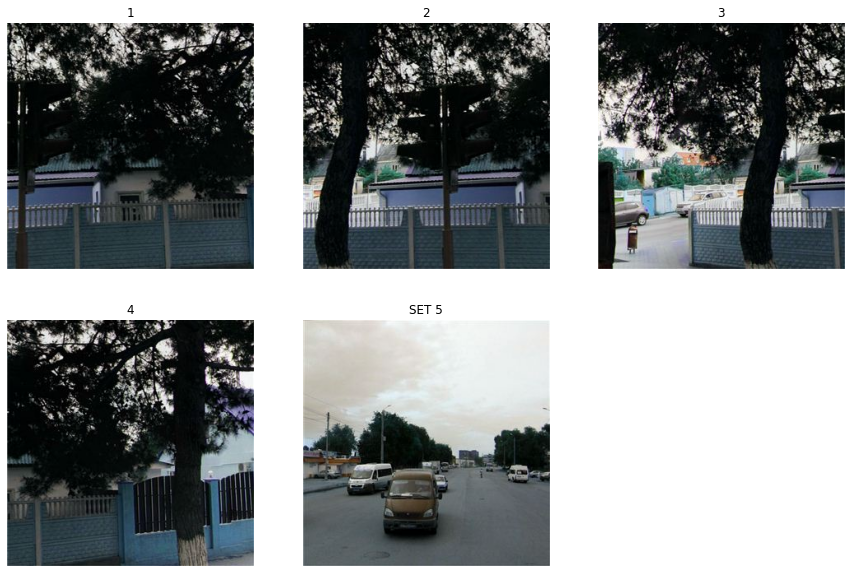

In [42]:
# Load images
paths = [path_tmpl % (image_group, i) for i in range(1,6)]
imgs = [cv.imread(path) for path in paths]

plt.figure(figsize=(15, 10))
for i, img in enumerate(imgs, 1):
    ax = plt.subplot(2, 3, i)
    plt.imshow(img)
    if i in learning_dict[image_group]:
        plt.title("SET %d" % i)
    else:
        plt.title("%d" % i)
    plt.axis("off")

In [43]:
# Initiate FAST object with default values
fast = cv.FastFeatureDetector_create()

In [44]:
kp_fast = []
for img in imgs:
    # generate Gaussian pyramids for 4 stages
    pyr1 = cv.pyrDown(img)
    pyr2 = cv.pyrDown(pyr1)
    pyr3 = cv.pyrDown(pyr2)

    # find and draw the keypoints
    kp1 = fast.detect(img, None)
    kp2 = fast.detect(pyr1, None)
    kp3 = fast.detect(pyr2, None)
    kp4 = fast.detect(pyr3, None)

    # combine local features from all stages
    kp = kp1 + kp2 + kp3 + kp4
    kp_fast.append(kp)

In [45]:
# calculate descriptors
surf = cv.xfeatures2d.SURF_create()
descriptions = []
kp_test = []
for i, kp in enumerate(kp_fast):
    kp_surf, des = surf.compute(imgs[i], kp)
    descriptions.append(des)
    kp_test.append(kp_surf)

In [46]:
# feature Matching with FLANN
matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_FLANNBASED)
most_similar = {1:0, 2:0, 3:0, 4:0, 5:0}
for i, des1 in enumerate(descriptions, 1):
    matching_number = []
    for j, des2 in enumerate(descriptions, 1):
        if i == j:
            matching_number.append(0)
            continue
        knn_matches = matcher.knnMatch(des1, des2, 2)
        ratio_thresh = 0.7
        good_matches = []
        for m,n in knn_matches:
            if m.distance < ratio_thresh * n.distance:
                good_matches.append(m)
        matching_number.append(len(good_matches))
    most_similar[i] = matching_number.index(max(matching_number)) + 1
print('Most similar pairs: ', most_similar)

# find one-to-one correspondences
print('Reliable one-to-one pairs: ')
for idx in most_similar:
    if most_similar[most_similar[idx]] == idx and most_similar[idx] > idx:
        print('Image ' + str(idx) + ' - ' + 'Image ' + str(most_similar[idx]))

Most similar pairs:  {1: 2, 2: 3, 3: 2, 4: 1, 5: 3}
Reliable one-to-one pairs: 
Image 2 - Image 3


In [47]:
# calculate the homography matrix using RANSAC scheme, apply filters
MIN_MATCH_COUNT = 100
labels = ['Image %d' % i for i in range(1, 6)]
inlayers = np.zeros((5, 5))
for i, des1 in enumerate(descriptions):
    for j, des2 in enumerate(descriptions):
        knn_matches = matcher.knnMatch(des1, des2, 2)
        ratio_thresh = 0.7
        good_matches = []
        for m,n in knn_matches:
            if m.distance < ratio_thresh * n.distance:
                good_matches.append(m)
        if len(good_matches) > MIN_MATCH_COUNT:
            # filter the remaining matches by the y coordinate
            src_pts = np.float32([kp_test[i][m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
            dst_pts = np.float32([kp_test[j][m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)
            angle1 = np.float32([kp_test[i][m.queryIdx].angle for m in good_matches]).reshape(-1,1,1)
            angle2 = np.float32([kp_test[j][m.trainIdx].angle for m in good_matches]).reshape(-1,1,1)
            for k in reversed(range(src_pts.shape[0])):
                if math.fabs(src_pts[k][0][1] - dst_pts[k][0][1]) > 100:
                    src_pts = np.delete(src_pts, k, axis=0)
                    dst_pts = np.delete(dst_pts, k, axis=0)
                else:
                    # orientation consistency check
                    maxa = max(angle1[k][0][0], angle2[k][0][0])
                    mina = min(angle1[k][0][0], angle2[k][0][0])
                    dist = min(maxa - mina, mina - maxa + 360)
                    if dist > 150:
                        src_pts = np.delete(src_pts, k, axis=0)
                        dst_pts = np.delete(dst_pts, k, axis=0)
            M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
            matchesMask = mask.ravel().tolist()
        else:
            matchesMask = None
        inlayers[i][j] = len(matchesMask) if matchesMask else 0
#         inlayers[i][j] = len(matchesMask) if (matchesMask and i != j) else 0
    
print('Confidence (inlayers):\n       img1  img2  img3  img4  img5')
for i in range(len(inlayers)):
    print('img', i+1, inlayers[i])

Confidence (inlayers):
       img1  img2  img3  img4  img5
img 1 [3216.  369.    0.  222.    0.]
img 2 [ 340. 3833.  435.    0.    0.]
img 3 [   0.  415. 4658.    0.    0.]
img 4 [ 266.    0.    0. 3298.    0.]
img 5 [   0.    0.    0.    0. 1250.]


In [48]:
inlayers /= np.max(inlayers)

array([0, 2, 3, 1, 0], dtype=int64)

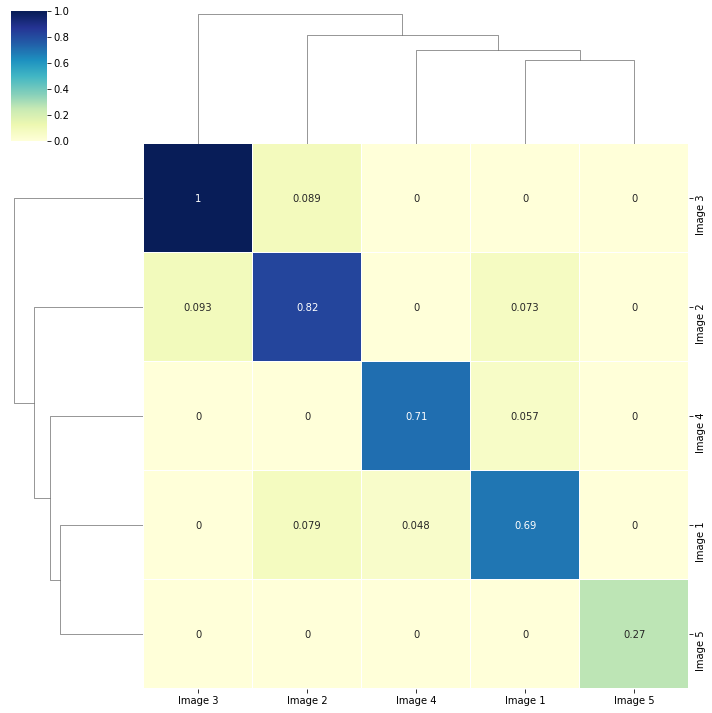

In [51]:
# draw cluster map
cg = sns.clustermap(
    inlayers, 
    xticklabels = labels,
    yticklabels = labels,
    cmap ="YlGnBu", 
    linewidths = 0.1,
    annot=True, square=False, cbar=True
)
clustering = AgglomerativeClustering(n_clusters=2).fit(inlayers)
clustering.labels_

In [21]:
# calculate accuracy
MIN_MATCH_COUNT = 100
fast = cv.FastFeatureDetector_create()
surf = cv.xfeatures2d.SURF_create()
matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_FLANNBASED)
true_positive_count = 0
for image_group, sets in learning_dict.items():
    
#     path_tmpl = str(PATH_PROJECT) + '/.data/imat2011/result_jpg_300/' + '%d_%d.jpg'
    path_tmpl = 'result_jpg_300/' + '%d_%d.jpg'
    
    paths = [path_tmpl % (image_group, i) for i in range(1,6)]
    imgs = [cv.imread(path) for path in paths]
    kp_fast = []
    for img in imgs:
        # generate Gaussian pyramids for 4 stages
        pyr1 = cv.pyrDown(img)
        pyr2 = cv.pyrDown(pyr1)
        pyr3 = cv.pyrDown(pyr2)

        # find and draw the keypoints
        kp1 = fast.detect(img, None)
        kp2 = fast.detect(pyr1, None)
        kp3 = fast.detect(pyr2, None)
        kp4 = fast.detect(pyr3, None)

        # combine local features from all stages
        kp = kp1 + kp2 + kp3 + kp4
        kp_fast.append(kp)
        
    # calculate descriptors
    descriptions = []
    kp_test = []
    for i, kp in enumerate(kp_fast):
        kp_surf, des = surf.compute(imgs[i], kp)
        descriptions.append(des)
        kp_test.append(kp_surf)
        
    inlayers = np.zeros((5, 5))
    try:
        for i, des1 in enumerate(descriptions):
            for j, des2 in enumerate(descriptions):
                knn_matches = matcher.knnMatch(des1, des2, 2)
                ratio_thresh = 0.7
                good_matches = []
                for m,n in knn_matches:
                    if m.distance < ratio_thresh * n.distance:
                        good_matches.append(m)
                if len(good_matches) > MIN_MATCH_COUNT:
                    # filter the remaining matches by the y coordinate
                    src_pts = np.float32([kp_test[i][m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
                    dst_pts = np.float32([kp_test[j][m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)
                    angle1 = np.float32([kp_test[i][m.queryIdx].angle for m in good_matches]).reshape(-1,1,1)
                    angle2 = np.float32([kp_test[j][m.trainIdx].angle for m in good_matches]).reshape(-1,1,1)
                    for k in reversed(range(src_pts.shape[0])):
                        if math.fabs(src_pts[k][0][1] - dst_pts[k][0][1]) > 100:
                            src_pts = np.delete(src_pts, k, axis=0)
                            dst_pts = np.delete(dst_pts, k, axis=0)
                        else:
                            # orientation consistency check
                            maxa = max(angle1[k][0][0], angle2[k][0][0])
                            mina = min(angle1[k][0][0], angle2[k][0][0])
                            dist = min(maxa - mina, mina - maxa + 360)
                            if dist > 150:
                                src_pts = np.delete(src_pts, k, axis=0)
                                dst_pts = np.delete(dst_pts, k, axis=0)
                    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
                    matchesMask = mask.ravel().tolist()
                else:
                    matchesMask = None
                inlayers[i][j] = len(matchesMask) if matchesMask else 0

        clustering = AgglomerativeClustering().fit(inlayers)

        clusters = defaultdict(set)
        for i, c in enumerate(clustering.labels_, 1):
            clusters[c].add(i)

        is_match = sum(1 for v in clusters.values() if v == sets)
        true_positive_count += is_match
        
    except:
        print('error')
        
accuracy = true_positive_count / len(learning_dict)
print('Accuracy: ' + str(100 * accuracy) + '%')

error
Accuracy: 20.744081172491544%
